In [1]:
import datetime
import os
import re
from collections import Counter
from datetime import datetime, timedelta

import numpy as np
from keras.preprocessing import sequence
import sys
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
import sklearn
from collections import Counter

from sklearn.metrics import pairwise_distances
import sys
sys.path.append('../')
from ftw_model.extract_feature import computing_feature_wo
from data_hh import load_dataset
import textdistance

/home/simon/miniconda3/envs/casas/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def read_hh_dataset(dataset_path):

    ann_dataset = pd.read_csv(dataset_path, sep='\t')

    raw_columns = ['Date & Time', 'Sensor ID', 'Room-level', 'Sensor location', 'Message', 'Sensor Type']
    ann_columns = raw_columns + ['Activity']

    ann_dataset.columns = ann_columns
    # ann_dataset['Activity'] = ann_dataset['Activity'].apply(lambda x: activity_mapping[x] if x in activity_mapping else x)

    ann_dataset['Date & Time'] = pd.to_datetime(ann_dataset['Date & Time'], format='%Y-%m-%d %H:%M:%S')
    start_time, end_time = ann_dataset['Date & Time'].min(), ann_dataset['Date & Time'].max()
    timeframed_dataset = ann_dataset.set_index(['Date & Time'])

    activity2id = {}
    count = 0
    for act in ann_dataset['Activity'].unique():
        if act != 'Other_Activity':
            activity2id[act] = count
            count += 1
    activity2id['Other_Activity'] = count
    
    return timeframed_dataset, start_time, end_time, activity2id

In [3]:
datasets_name = ['1' + str(i) if i >= 10 else '10' + str(i) for i in range(1, 31)]
activities_list = []
for i in datasets_name:
    df, start, end, activity2id = read_hh_dataset('../hh_dataset/hh' + i + '/hh' + i + '.ann.txt')
    # df.to_csv('../hh_dataset/hh' + i + '/hh' + i + '.ann.csv')
    activities_list.append(list(activity2id.keys())[:-1])
print(np.mean([len(i) for i in activities_list]))


32.13333333333333


In [4]:
j = '101'
df, start, end, activity2id = read_hh_dataset('../hh_dataset/hh' + j + '/hh' + j + '.ann.txt')
number_of_days = int((end - start).days) + 1
print('Number of days: ', number_of_days)

Number of days:  60


### Define similar activities by normalized Edit Distance and agglomerative clustering

In [5]:
X, Y, dictActivities = load_dataset('../hh_dataset/hh' + j + '/hh' + j + '.ann.txt')
inversed_dictActivities = {v: k for k, v in dictActivities.items()}

{'Bathe': 0, 'Bed_Toilet_Transition': 1, 'Cook': 2, 'Cook_Breakfast': 3, 'Cook_Dinner': 4, 'Cook_Lunch': 5, 'Dress': 6, 'Drink': 7, 'Eat': 8, 'Eat_Breakfast': 9, 'Eat_Dinner': 10, 'Eat_Lunch': 11, 'Enter_Home': 12, 'Entertain_Guests': 13, 'Evening_Meds': 14, 'Go_To_Sleep': 15, 'Groom': 16, 'Leave_Home': 17, 'Morning_Meds': 18, 'Other_Activity': 19, 'Personal_Hygiene': 20, 'Phone': 21, 'Read': 22, 'Relax': 23, 'Sleep': 24, 'Sleep_Out_Of_Bed': 25, 'Step_Out': 26, 'Toilet': 27, 'Wake_Up': 28, 'Wash_Breakfast_Dishes': 29, 'Wash_Dinner_Dishes': 30, 'Wash_Dishes': 31, 'Wash_Lunch_Dishes': 32, 'Watch_TV': 33, 'Work_At_Table': 34}


ValueError: too many values to unpack (expected 3)

In [ ]:
dictActivities

In [ ]:
Counter([inversed_dictActivities[i] for i in Y])

In [ ]:
# Get x of Cook_Breakfast, Cook_Dinner, Cook_Lunch, Cook
x_cook_breakfast = [x for x, y in zip(X, Y) if inversed_dictActivities[y] == 'Cook_Breakfast']
x_cook_dinner = [x for x, y in zip(X, Y) if inversed_dictActivities[y] == 'Cook_Dinner']
x_cook_lunch = [x for x, y in zip(X, Y) if inversed_dictActivities[y] == 'Cook_Lunch']
x_cook = [x for x, y in zip(X, Y) if inversed_dictActivities[y] == 'Cook']

# Total length of Cook_Breakfast, Cook_Dinner, Cook_Lunch, Cook
print('Total length of Cook: ', len(x_cook_breakfast) + len(x_cook_dinner) + len(x_cook_lunch) + len(x_cook))

# Filter the lower 40 percentile of length of Cook_Breakfast, Cook_Dinner, Cook_Lunch, Cook
x_cook_breakfast = [x for x in x_cook_breakfast if len(x) > np.percentile([len(x) for x in x_cook_breakfast], 30)]
x_cook_dinner = [x for x in x_cook_dinner if len(x) > np.percentile([len(x) for x in x_cook_dinner], 30)]
x_cook_lunch = [x for x in x_cook_lunch if len(x) > np.percentile([len(x) for x in x_cook_lunch], 30)]
x_cook = [x for x in x_cook if len(x) > np.percentile([len(x) for x in x_cook], 30)]

# Total length of Cook_Breakfast, Cook_Dinner, Cook_Lunch, Cook
print('Total length of Cook: ', len(x_cook_breakfast) + len(x_cook_dinner) + len(x_cook_lunch) + len(x_cook))


In [ ]:
# Get x of Eat_Breakfast, Eat_Dinner, Eat_Lunch, Eat
x_eat_breakfast = [x for x, y in zip(X, Y) if inversed_dictActivities[y] == 'Eat_Breakfast']
x_eat_dinner = [x for x, y in zip(X, Y) if inversed_dictActivities[y] == 'Eat_Dinner']
x_eat_lunch = [x for x, y in zip(X, Y) if inversed_dictActivities[y] == 'Eat_Lunch']
x_eat = [x for x, y in zip(X, Y) if inversed_dictActivities[y] == 'Eat']

# Total length of Eat_Breakfast, Eat_Dinner, Eat_Lunch, Eat
print('Total length of Eat: ', len(x_eat_breakfast) + len(x_eat_dinner) + len(x_eat_lunch) + len(x_eat))

# Filter the lower 40 percentile of length of Eat_Breakfast, Eat_Dinner, Eat_Lunch, Eat
x_eat_breakfast = [x for x in x_eat_breakfast if len(x) > np.percentile([len(x) for x in x_eat_breakfast], 30)]
x_eat_dinner = [x for x in x_eat_dinner if len(x) > np.percentile([len(x) for x in x_eat_dinner], 30)]
x_eat_lunch = [x for x in x_eat_lunch if len(x) > np.percentile([len(x) for x in x_eat_lunch], 30)]
x_eat = [x for x in x_eat if len(x) > np.percentile([len(x) for x in x_eat], 30)]

# Total length of Eat_Breakfast, Eat_Dinner, Eat_Lunch, Eat
print('Total length of Eat: ', len(x_eat_breakfast) + len(x_eat_dinner) + len(x_eat_lunch) + len(x_eat))


In [ ]:
# Check x where y == 'Cook_Breakfast'
x_cook_dinner = [x for x, y in zip(X, Y) if y == 4]
len(x_cook_dinner)

In [ ]:
# Filter the lower 30% of the length of x_cook_breakfast
x_cook_dinner_lower = [x for x in x_cook_dinner if len(x) > np.percentile([len(x) for x in x_cook_dinner], 40)]
len(x_cook_dinner_lower)

In [ ]:
# Filter the lower 30% of the length of x_cook_breakfast
x_cook_breakfast_lower = [x for x in x_cook_breakfast if len(x) > np.percentile([len(x) for x in x_cook_breakfast], 40)]
len(x_cook_breakfast_lower)

In [ ]:
X_work_on_computer = [x for i, x in enumerate(X) if Y[i] == dictActivities['Work_On_Computer']]
X_work = [x for i, x in enumerate(X) if Y[i] == dictActivities['Work']]
X_sleep = [x for i, x in enumerate(X) if Y[i] == dictActivities['Sleep']]
X_work_at_table = [x for i, x in enumerate(X) if Y[i] == dictActivities['Work_At_Table']]
X_cook = [x for i, x in enumerate(X) if Y[i] == dictActivities['Cook']]
X_eat = [x for i, x in enumerate(X) if Y[i] == dictActivities['Eat']]
X_eat_lunch = [x for i, x in enumerate(X) if Y[i] == dictActivities['Eat_Lunch']]
X_eat_breakfast = [x for i, x in enumerate(X) if Y[i] == dictActivities['Eat_Breakfast']]
X_eat_dinner = [x for i, x in enumerate(X) if Y[i] == dictActivities['Eat_Dinner']]
X_cook_lunch = [x for i, x in enumerate(X) if Y[i] == dictActivities['Cook_Lunch']]
X_wash_dishes = [x for i, x in enumerate(X) if Y[i] == dictActivities['Wash_Dishes']]
X_cook_breakfast = [x for i, x in enumerate(X) if Y[i] == dictActivities['Cook_Breakfast']]
X_cook_dinner = [x for i, x in enumerate(X) if Y[i] == dictActivities['Cook_Dinner']]
# X_drink = [x for i, x in enumerate(X) if Y[i] == dictActivities['Drink']]
# textdistance.levenshtein.normalized_similarity(X_work_on_computer[0], X_work_on_computer[1])

In [ ]:
# Print the mean distance between eat itself, eat lunch and eat
print('Eat: ', np.mean([textdistance.levenshtein.normalized_distance(x, y) for x in X_eat for y in X_eat]))
print('Eat lunch: ', np.mean([textdistance.levenshtein.normalized_distance(x, y) for x in X_eat_lunch for y in X_eat_lunch]))
print('Eat and eat lunch: ', np.mean([textdistance.levenshtein.normalized_distance(x, y) for x in X_eat for y in X_eat_lunch]))
# Print the mean distance between eat and work
print('Eat and work: ', np.mean([textdistance.levenshtein.normalized_distance(x, y) for x in X_eat for y in X_work]))

In [ ]:
# Print the mean distance between eat lunch and cook lunch
# print the mean distance between cook lunch itself, cook lunch and cook
print('Cook lunch: ', np.mean([textdistance.levenshtein.normalized_distance(x, y) for x in X_cook_lunch for y in X_cook_lunch]))
print('Eat lunch and cook lunch: ', np.mean([textdistance.levenshtein.normalized_distance(x, y) for x in X_eat_lunch for y in X_cook_lunch]))
print('Cook lunch and cook: ', np.mean([textdistance.levenshtein.normalized_distance(x, y) for x in X_cook_lunch for y in X_cook]))

In [ ]:
# Print the mean distance between eat, eat lunch, eat breakfast and eat dinner
print('Eat: ', np.mean([textdistance.levenshtein.normalized_distance(x, y) for x in X_eat for y in X_eat]))
print('Eat lunch: ', np.mean([textdistance.levenshtein.normalized_distance(x, y) for x in X_eat_lunch for y in X_eat_lunch]))
print('Eat breakfast: ', np.mean([textdistance.levenshtein.normalized_distance(x, y) for x in X_eat_breakfast for y in X_eat_breakfast]))
print('Eat dinner: ', np.mean([textdistance.levenshtein.normalized_distance(x, y) for x in X_eat_dinner for y in X_eat_dinner]))
print('Eat and eat lunch: ', np.mean([textdistance.levenshtein.normalized_distance(x, y) for x in X_eat for y in X_eat_lunch]))
print('Eat and eat breakfast: ', np.mean([textdistance.levenshtein.normalized_distance(x, y) for x in X_eat for y in X_eat_breakfast]))
print('Eat and eat dinner: ', np.mean([textdistance.levenshtein.normalized_distance(x, y) for x in X_eat for y in X_eat_dinner]))

# Print the mean distance between eat breakfast and eat lunch
print('Eat breakfast and eat lunch: ', np.mean([textdistance.levenshtein.normalized_distance(x, y) for x in X_eat_breakfast for y in X_eat_lunch]))
# Print the mean distance between eat breakfast and eat dinner
print('Eat breakfast and eat dinner: ', np.mean([textdistance.levenshtein.normalized_distance(x, y) for x in X_eat_breakfast for y in X_eat_dinner]))
# Print the mean distance between eat lunch and eat dinner
print('Eat lunch and eat dinner: ', np.mean([textdistance.levenshtein.normalized_distance(x, y) for x in X_eat_lunch for y in X_eat_dinner]))

In [ ]:
# Print the mean distance between eat lunch and cook lunch
print('Eat lunch and cook lunch: ', np.mean([textdistance.levenshtein.normalized_distance(x, y) for x in X_eat_lunch for y in X_cook_lunch]))
# Print the mean distance between eat breakfast and cook breakfast
print('Eat breakfast and cook breakfast: ', np.mean([textdistance.levenshtein.normalized_distance(x, y) for x in X_eat_breakfast for y in X_cook_breakfast]))
# Print the mean distance between eat dinner and cook dinner
print('Eat dinner and cook dinner: ', np.mean([textdistance.levenshtein.normalized_distance(x, y) for x in X_eat_dinner for y in X_cook_dinner]))

In [ ]:
# {'Eat': 0, 'Eat_Lunch': 1, 'Toilet': 2, 'Wash_lunch_dishes':3, 'Wash_dishes':4}
X_eat = [x for i, x in enumerate(X) if Y[i] == dictActivities['Eat']]
X_eat_lunch = [x for i, x in enumerate(X) if Y[i] == dictActivities['Eat_Lunch']]
X_toilet = [x for i, x in enumerate(X) if Y[i] == dictActivities['Toilet']]
X_wash_lunch_dishes = [x for i, x in enumerate(X) if Y[i] == dictActivities['Wash_Lunch_Dishes']]
X_wash_dishes = [x for i, x in enumerate(X) if Y[i] == dictActivities['Wash_Dishes']]

activitiy_list = ['Eat', 'Eat_Lunch', 'Toilet', 'Wash_Lunch_Dishes', 'Wash_Dishes']

sim_matrix = np.zeros((len(activitiy_list), len(activitiy_list)))
# COmpute the similarity matrix with the mean distance between each activity
for i in trange(len(activitiy_list)):
    for j in trange(len(activitiy_list)):
        if i == j:
            sim_matrix[i][j] = np.mean([textdistance.levenshtein.normalized_similarity(x, y) for x in globals()['X_' + activitiy_list[i].lower()] for y in globals()['X_' + activitiy_list[j].lower()]])
        else:
            sim_matrix[i][j] = np.mean([textdistance.levenshtein.normalized_similarity(x, y) for x in globals()['X_' + activitiy_list[i].lower()] for y in globals()['X_' + activitiy_list[j].lower()]])
            sim_matrix[j][i] = sim_matrix[i][j]

In [ ]:
pd.DataFrame(sim_matrix, index=activitiy_list, columns=activitiy_list)

In [ ]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
# Plot the dendrogram
sim_matrix_no_diag = sim_matrix.copy()
np.fill_diagonal(sim_matrix_no_diag, 0)
plt.figure(figsize=(10, 7))
plt.title("Dendrograms")
dend = dendrogram(linkage(squareform(sim_matrix_no_diag), method='complete'), labels=activitiy_list)
plt.show()
# set diagonal to 0

In [ ]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
# Plot the dendrogram
sim_matrix_dist_no_diag = sim_matrix_dist.copy()
np.fill_diagonal(sim_matrix_dist_no_diag, 0)
plt.figure(figsize=(10, 7))
plt.title("Dendrograms")
dend = dendrogram(linkage(squareform(sim_matrix_dist_no_diag), method='complete'), labels=activitiy_list)
plt.show()
# set diagonal to 0

In [ ]:
# Print the mean distance between drink and wash dishes
print('Drink and wash dishes: ', np.mean([textdistance.levenshtein.normalized_distance(x, y) for x in X_drink for y in X_wash_dishes]))

In [ ]:
np.mean([textdistance.levenshtein.normalized_similarity(X_work_on_computer[i], X_work_on_computer[j]) for i in range(len(X_work_on_computer)) for j in range(i+1, len(X_work_on_computer))])

In [ ]:
np.mean([textdistance.levenshtein.normalized_distance(X_work[i], X_work[j]) for i in range(len(X_work)) for j in range(i+1, len(X_work))])

In [ ]:
np.mean([textdistance.levenshtein.normalized_distance(X_cook[i], X_work[j]) for i in range(len(X_cook)) for j in range(len(X_work))])

In [ ]:
np.mean([textdistance.levenshtein.normalized_distance(X_work_at_table[i], X_work_on_computer[j]) for i in range(len(X_work_at_table)) for j in range(len(X_work_on_computer))])

In [ ]:
np.mean([textdistance.levenshtein.normalized_distance(X_work_at_table[i], X_work[j]) for i in range(len(X_work_at_table)) for j in range(len(X_work))])

In [ ]:
np.mean([textdistance.levenshtein.normalized_distance(X_work_at_table[i], X_work[j]) for i in range(len(X_work_at_table)) for j in range(len(X_work))])

In [ ]:
linkage_data = linkage(list(X), method='ward', metric='euclidean')
dendrogram(linkage_data, labels=[dictActivities[y] for y in Y], orientation='right')

## Define activities mapping and FTW details

In [ ]:
activity_mapping = {
                              "Cook_Breakfast": "Cook",
                              "Cook_Lunch": "Cook",
                              "Cook_Dinner": "Cook",
                              "Eat_Breakfast": "Eat",
                              "Eat_Lunch": "Eat",
                              "Eat_Dinner": "Eat",
                              "Morning_Meds": "Take_Medicine",
                              "Evening_Meds": "Take_Medicine",
                              "Wash_Breakfast_Dishes": "Wash_Dishes",
                              "Wash_Lunch_Dishes": "Wash_Dishes",
                              "Wash_Dinner_Dishes": "Wash_Dishes",
                              "Work_At_Table": "Work",
                              "Watch_TV": "Relax",
                              "Read": "Work",
                              "Entertain_Guests": "Relax",
                              "Sleep_Out_Of_Bed": "Relax",
                              "Step_Out": "Leave_Home",
                     }
FTWs = [720, 540, 360, 180, 60, 30, 15, 5, 3, 2, 1, 0, 0]
# FTWs = [0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144][::-1]
ftw_window = 10

In [ ]:
%matplotlib inline

n = 10
fig = plt.figure(figsize=(20, 4))
color = sns.color_palette().as_hex()
for i in range(n):
    c = color[i]
    l4, l3, l2, l1 = FTWs[i:i+4]
    plt.plot((-l4, -l3), (0, 1), c=c)
    plt.plot((-l3, -l2), (1, 1), c=c)
    plt.plot((-l2, -l1), (1, 0), c=c)
plt.show()

In [ ]:
def read_hh_dataset(dataset_path):

    ann_dataset = pd.read_csv(dataset_path, sep='\t')

    raw_columns = ['Date & Time', 'Sensor ID', 'Room-level', 'Sensor location', 'Message', 'Sensor Type']
    ann_columns = raw_columns + ['Activity']

    ann_dataset.columns = ann_columns
    ann_dataset['Activity'] = ann_dataset['Activity'].apply(lambda x: activity_mapping[x] if x in activity_mapping else x)

    ann_dataset['Date & Time'] = pd.to_datetime(ann_dataset['Date & Time'], format='%Y-%m-%d %H:%M:%S')
    start_time, end_time = ann_dataset['Date & Time'].min(), ann_dataset['Date & Time'].max()
    timeframed_dataset = ann_dataset.set_index(['Date & Time'])

    activity2id = {}
    count = 0
    for act in ann_dataset['Activity'].unique():
        if act != 'Other_Activity':
            activity2id[act] = count
            count += 1
    activity2id['Other_Activity'] = count
    
    return timeframed_dataset, start_time, end_time, activity2id

In [ ]:
hh_dataset = [f'hh1{str(i) if i >=10 else "0"+str(i)}' for i in range(1, 31)]
# activity = set()
# total_data = 0
# for file in hh_dataset:
#     if file == 'hh121':
#         continue
#     ann_dataset, start, end, activity2id = read_hh_dataset(f'../hh_dataset/{file}/{file}.ann.txt')
#     total_data += len(ann_dataset[ann_dataset['Activity'] != 'Other_Activity'])
#     activity = activity.union(activity2id)
# # activity
# total_data

In [ ]:
file = 'hh102'
timeframed_dataset, start_time, end_time, activity2id = read_hh_dataset(f'../hh_dataset/{file}/{file}.ann.txt')

In [ ]:
activity2id = {}
count = 0
for act in timeframed_dataset['Activity'].unique():
    if act != 'Other_Activity':
        activity2id[act] = count
        count += 1
activity2id['Other_Activity'] = count
activity2id

In [ ]:
delta = timedelta(days=1)
number_of_days = int(np.ceil((end_time - start_time) / delta))

df_activities = [[] for _ in range(len(activity2id))]

# activities = np.zeros((number_of_days, len(activity2id)-1))
for i in range(number_of_days):
    activity_within_range = timeframed_dataset[start_time+i*delta: start_time+(i+1)*delta]
    # activity_within_range['time'] = activity_within_range.index.time
    # activity_within_range.set_index(activity_within_range['time'], inplace=True)
    for i, act in enumerate(activity2id):
        df_activities[i].append(activity_within_range[activity_within_range['Activity'] == act])

In [ ]:
choice = 4
print(list(activity2id.keys())[choice])
testing = pd.concat(df_activities[choice]).sort_index()
# testing.groupby(testing.index.hour).count()
# pd.to_datetime(testing['time'], format='%X')
# testing['Activity'].groupby(pd.Grouper(freq='H')).count()
testing['time'] = testing.index
testing['time'] = testing['time'].apply(lambda dt: dt.replace(day=1).replace(month=1).replace(year=1900))
testing.set_index(testing['time'], inplace=True)

f= lambda x: x.reindex(pd.date_range(x.index.min().floor('d'),
                                      x.index.min().floor('d')+pd.Timedelta(23, 'H'),freq='H'))
x = testing.groupby(pd.Grouper(freq='H')).count()
f(x)['Activity'].plot(kind='bar')

In [ ]:
light_sensor_df = timeframed_dataset[timeframed_dataset['Sensor ID'].apply(lambda x : x[0:2] == "LS")]

light_sensor_activity_list = list(light_sensor_df['Activity'].unique())

fig, axs = plt.subplots(4, 5, figsize=(25, 15), constrained_layout=True)
for i, act in enumerate(light_sensor_activity_list):
    act_light_readings = light_sensor_df[light_sensor_df['Activity'] == act]['Message']

    counter = {int(k): v for k, v in Counter(act_light_readings).items()}
    axs[i//5][i % 5].bar(counter.keys(), counter.values())
    axs[i//5][i % 5].axvline(x=50, linewidth=2, color='r')
    axs[i//5][i % 5].title.set_text(act)
# plt.xlabel("common X")
# plt.ylabel("common Y")
# plt.show()

fig.suptitle('Light sensors reading histogram for each activities', size=35)
fig.supxlabel('Light Intensity(0 means dimmest; 100 means brightest)', size=25)
fig.supylabel('Frequency', size=25)
plt.savefig('./figure/light_sensor_reading_plot.png', dpi=150, bbox_inches="tight")

In [ ]:
Counter(light_sensor_df['Sensor ID'])

In [ ]:
Counter(light_sensor_df[light_sensor_df['Message'].apply(lambda x : int(x) > 50)]['Sensor ID'])

In [ ]:
timeframed_dataset[(timeframed_dataset['Sensor Type'] == 'Control4-Light') & (timeframed_dataset['Activity'] != 'Other_Activity')]['Room-level'].unique()

In [ ]:
# Plot the Light sensor reading distribution
counter = Counter(timeframed_dataset[timeframed_dataset['Sensor ID'].apply(lambda x : x[:2] == "LS")]['Message'])


counter = {int(k): v for k, v in counter.items()}
plt.bar(counter.keys(), counter.values())
plt.axvline(x=50, linewidth=2, color='r')

plt.xlabel('Light Intensity', size=10)
plt.ylabel('Frequency', size=10)
plt.title('Light sensors reading histogram', size=15)
plt.show()

# Compute the activity input

In [ ]:
## TODO reduce the time delta and compute the result between different time window

delta = timedelta(minutes=2)

number_of_time_window = int(np.ceil((end_time - start_time) / delta))
activities = np.zeros((number_of_time_window, len(activity2id)-1))
# timeframed_dataset[start_time: start_time+delta]
for i in range(number_of_time_window):
    activity_within_range = timeframed_dataset[start_time+i*delta: start_time+(i+1)*delta]['Activity'].unique()
    for j in activity_within_range:
        if j == "Other_Activity":
            continue
        else:
            activities[i][activity2id[j]] = 1

In [ ]:
def get_time_window(offset):
    return timeframed_dataset[start_time+offset*delta: start_time+(offset+1)*delta]

## T-SNE on the features

In [ ]:
# Plotting the scatter plot
activities_plot = ['Drink', 'Phone', 'Take_Medicine']
for i, activity in enumerate(activities_plot):
    activity_vector = np.zeros(len(activity2id)-1)
    activity_index = [i for i, act in enumerate(activities) if (act[activity2id[activity]] == 1)]
    activity_feature_vector = np.array([feature for i, feature in enumerate(features) if i in activity_index])

    print(f'{activity}: shape{activity_feature_vector.shape}')
    instance, _, _ = activity_feature_vector.shape
    sleep_feature_vectors = activity_feature_vector.reshape((instance, -1))

    dim_reducer=umap.UMAP()
    scaled_data = StandardScaler().fit_transform(sleep_feature_vectors)
    embedding = dim_reducer.fit_transform(scaled_data)
    color_mapping = sns.color_palette("tab10", len(activities))

    plt.scatter(embedding[:, 0], embedding[:, 1], color=color_mapping[i], label=activity)
plt.legend()

In [ ]:
# Plotting the scatter plot
activities_plot = ['Phone', 'Drink', 'Take_Medicine', 'Wash_Dishes', 'Toilet', 'Dress']
for i, activity in enumerate(activities_plot):
    activity_vector = np.zeros(len(activity2id)-1)
    activity_index = [i for i, act in enumerate(activities) if (act[activity2id[activity]] == 1)]
    activity_feature_vector = np.array([feature for i, feature in enumerate(features) if i in activity_index])

    print(f'{activity}: shape{activity_feature_vector.shape}')
    instance, _, _ = activity_feature_vector.shape
    sleep_feature_vectors = activity_feature_vector.reshape((instance, -1))

    dim_reducer=umap.UMAP()
    scaled_data = StandardScaler().fit_transform(sleep_feature_vectors)
    embedding = dim_reducer.fit_transform(scaled_data)
    color_mapping = sns.color_palette("tab10", len(activities))

    plt.scatter(embedding[:, 0], embedding[:, 1], color=color_mapping[i], label=activity)
plt.legend()

In [ ]:
instance, _, _ = features.shape
flatten_feature = features.reshape((instance, -1))
feature_counting_non_zero = [(i, np.count_nonzero(x > 0)) for i, x in enumerate(flatten_feature)]
act_counting_non_zero = [np.count_nonzero(x > 0) for i, x in enumerate(activities)]
np.argmax(act_counting_non_zero)
get_time_window(926)

## Agglomerative clustering

ValueError: Distance matrix 'X' must be symmetric.

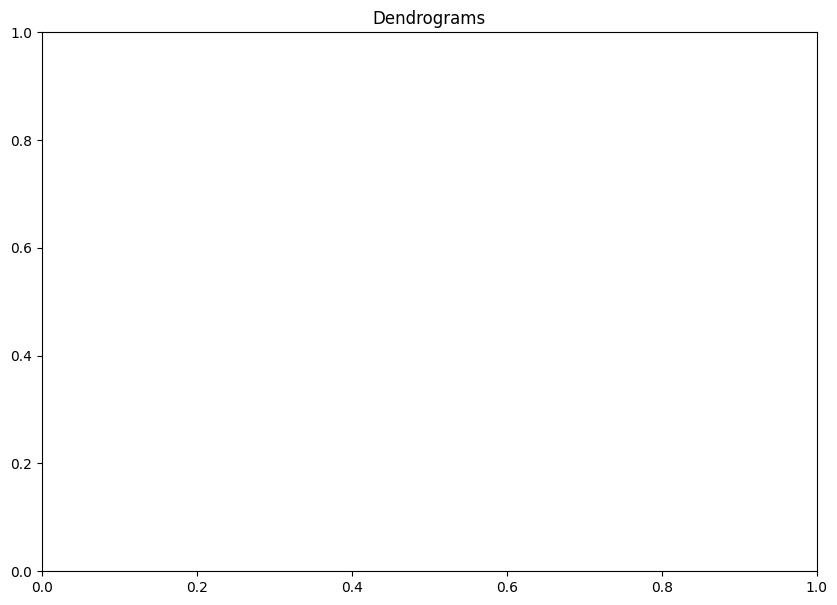

In [11]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Plot the dendrogram
# load the similarity matrix from the file 
sim_matrix_dist = pd.read_csv('../similarity_matrix/hh_124/sim_matrix.csv', index_col=0)
activitiy_list = sim_matrix_dist.columns

sim_matrix_dist_no_diag = sim_matrix_dist.copy().to_numpy()
np.fill_diagonal(sim_matrix_dist_no_diag, 0)
plt.figure(figsize=(10, 7))
plt.title("Dendrograms")
dend = dendrogram(linkage(1 - squareform(sim_matrix_dist_no_diag), method='complete'), labels=activitiy_list, leaf_rotation=0, orientation='right')

plt.title(f'Agglomerative Hierarchical Clustering Dendrogram for hh127 dataset')
# set anchor labels bold in y ticks
        # label.set_color('red')
# draw a horizontal line at x = 0.25
# ax.axvline(x=0.4* np.sum([np.min(sim_matrix_dist_no_diag), np.max(sim_matrix_dist_no_diag)]), color='k', linestyle='--')
# ax.set_xlabel('Normalized Edit Distance')

# save the figure
# plt.savefig(f'./clustering_figure/cairo.png', dpi=300, bbox_inches='tight')

In [14]:
dropping_labels = ['Work_On_Computer', 'Work', 'Take_Medicine', 'Work_At_Desk', 'Go_To_Sleep', 'Wake_Up', 'Exercise', 'Nap', 'Laundry', 'r1.Sleep', 'r1.Cook_Breakfast', 'r2.Personal_Hygiene', 'r2.Eat_Breakfast', 'r2.Dress']
len(dropping_labels)

14

hh103, hh106, hh109, hh113, hh115, hh117, hh118, hh119, hh121, hh123, hh125

Index(['Bed_Toilet_Transition', 'Cook_Dinner', 'Dress', 'Drink', 'Eat_Dinner',
       'Enter_Home', 'Entertain_Guests', 'Groom', 'Leave_Home',
       'Personal_Hygiene', 'Phone', 'Read', 'Sleep', 'Sleep_Out_Of_Bed',
       'Step_Out', 'Toilet', 'Wash_Breakfast_Dishes', 'Wash_Dinner_Dishes',
       'Wash_Dishes', 'Watch_TV', 'Work', 'Work_At_Table', 'Work_On_Computer'],
      dtype='object')
                       Bed_Toilet_Transition  Cook_Dinner     Dress  Drink  \
Bed_Toilet_Transition               0.760044     0.000000  0.000000    0.0   
Cook_Dinner                         0.000000     0.736111  0.000000    0.0   
Dress                               0.000000     0.000000  0.488424    0.0   
Drink                               0.000000     0.000000  0.000000    0.0   
Eat_Dinner                          0.000000     0.006944  0.000000    0.0   
Enter_Home                          0.003539     0.013609  0.006746    0.0   
Entertain_Guests                    0.047780     0.050949  0

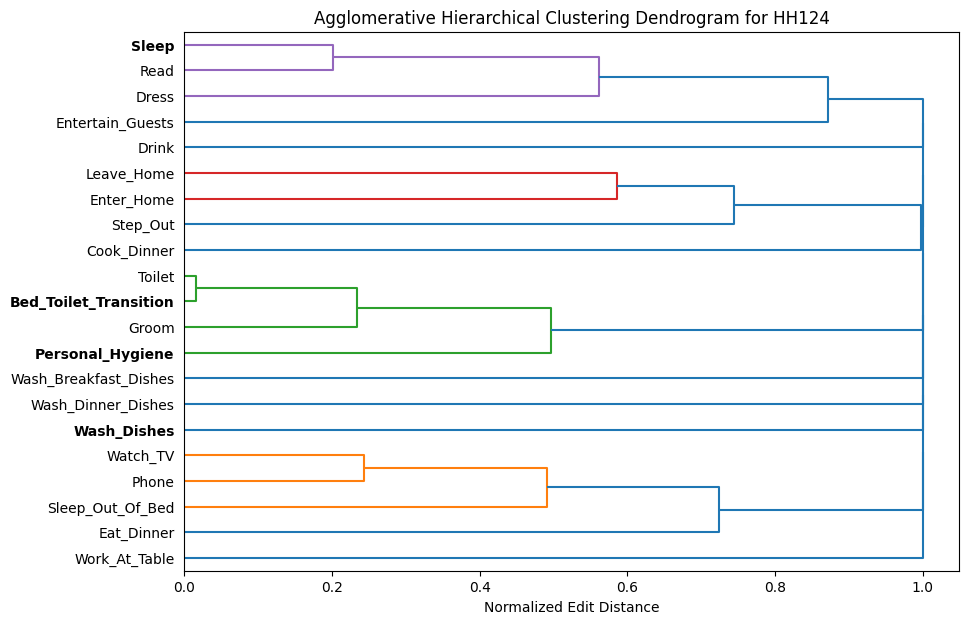

In [15]:
# Check pair name overlap between activity within activity list
for data in range(24, 25):

    sim_path = f'../similarity_matrix/hh_1{"0" + str(data) if data < 10 else data}/sim_matrix.csv'
    # check if the file exist
    if not os.path.isfile(sim_path):
        continue
    sim_matrix_dist = pd.read_csv(sim_path, index_col=0).fillna(0)

    print(sim_matrix_dist.columns)
    # filter label both from index and column if in the dropping list

    drop = [i for i in sim_matrix_dist.columns if i in dropping_labels]
    sim_matrix_dist = sim_matrix_dist.drop(columns=drop, index=drop)

    activitiy_list = sim_matrix_dist.columns
    
    a = [(i, j) for i in activitiy_list for j in activitiy_list if set(i.split('_')).intersection(set(j.split('_'))) and i != j and 'Home' not in i and 'Home' not in j and 'Toliet' not in i and 'Toliet' not in j and 'Bed' not in i and 'Bed' not in j and 'Other' not in i and 'Other' not in j]

    # filter out the pair that already in the list with different order
    b = []
    for i, j in a:

        if (j, i) not in b:
            b.append((i, j))
    for i, j in b:
        if ('Meds' in i) and ('Meds' in j):
            sim_matrix_dist[i][j] += min(sim_matrix_dist[i][i], sim_matrix_dist[j][j]) / 10
            sim_matrix_dist[j][i] += min(sim_matrix_dist[i][i], sim_matrix_dist[j][j]) / 10
        elif ('Toliet' in i) and ('Toliet' in j):
            sim_matrix_dist[i][j] += min(sim_matrix_dist[i][i], sim_matrix_dist[j][j]) / 10
            sim_matrix_dist[j][i] += min(sim_matrix_dist[i][i], sim_matrix_dist[j][j]) / 10
        # else:
        #     sim_matrix_dist[i][j] += min(sim_matrix_dist[i][i], sim_matrix_dist[j][j]) / 10
        #     sim_matrix_dist[j][i] += min(sim_matrix_dist[i][i], sim_matrix_dist[j][j]) / 10


    # anchor labels = Bathe, Enter home, Wash dishes, Relax, Work, Sleep, Leave home, cook, eat, personal hygiene, bed toilet transition
    anchor_labels = ['Bathe', 'Enter_home', 'Wash_Dishes', 'Relax', 'Work', 'Sleep', 'Leave_home', 'Cook', 'Eat', 'Personal_Hygiene', 'Bed_Toilet_Transition']

    print(sim_matrix_dist)

    sim_matrix_dist_no_diag = sim_matrix_dist.copy().to_numpy()
    np.fill_diagonal(sim_matrix_dist_no_diag, 0)
    fig, ax = plt.subplots(figsize=(10, 7))
    plt.title("Dendrograms")

    link = linkage(np.max(sim_matrix_dist_no_diag) + 0.01  - squareform(sim_matrix_dist_no_diag), method='complete')

    # map the link back to [0, 1]
    link[:, 2] = link[:, 2] / np.max(link[:, 2])

    dend = dendrogram(link, labels=activitiy_list, leaf_rotation=0, orientation='right')
    plt.title(f'Agglomerative Hierarchical Clustering Dendrogram for HH1{str(data) if data > 9 else "0" + str(data)}')
    # set anchor labels bold in y ticks
    for i, label in enumerate(ax.get_yticklabels()):
        if label.get_text() in anchor_labels:
            label.set_weight('bold')
            # label.set_color('red')
    # draw a horizontal line at x = 0.25
    # ax.axvline(x=0.4* np.sum([np.min(sim_matrix_dist_no_diag), np.max(sim_matrix_dist_no_diag)]), color='k', linestyle='--')
    ax.set_xlabel('Normalized Edit Distance')
    
    # save the figure
    # plt.savefig(f'./clustering_figure/hh_1{"0" + str(data) if data < 10 else data}.png', dpi=300, bbox_inches='tight')


In [ ]:
np.max(sim_matrix_dist_no_diag)

In [ ]:
sim_matrix_dist.columns

In [ ]:
# get the max similarity column for evening meds
print(list(sim_matrix_dist.columns)[np.argsort(sim_matrix_dist['Relax'].to_numpy())[-1]])

In [ ]:
import sys
sys.path.append('../')
from data_hh import load_dataset

dataset_no = '101'

dataset_path = '../hh_dataset/hh' + dataset_no + '/hh' + dataset_no + '.ann.txt'
print('Dataset loaded')

# Load the data
X, Y, dictActivities = load_dataset(dataset_path)
print('Data loaded')

y_act = np.array([y for y in dictActivities if y != 'Other_Activity'])
X_activities = [[x for i, x in enumerate(X) if Y[i] == dictActivities[y]] for y in y_act]
# filter X_activities to filter less than 40 quantile
print(len(X_activities))
# filter elements in X_activities that length has less than 40 quantile

In [ ]:
X_activities = [[ x]  for x in X_activities]

In [ ]:
y_act[0]

In [ ]:
dishes = 0
dishes_filter = 0
# For loop those that contain dishes
for i, x in enumerate(X_activities):
    if 'Sleep' == y_act[i]:
        print(i)
        print(y_act[i])
        dishes += len(x)
        dishes_filter += len([y for y in x if len(y) > np.quantile([len(y) for y in x], 0.2)])

print(dishes)
print(dishes_filter)

In [ ]:
import multiprocessing as mp
mp.cpu_count()

### Dataset characteristics

In [6]:
apt_id = ['hh. ' + '1' + '0' + str(i) for i in range(1, 10)] + ['hh. ' + '1' + str(i) for i in range(10, 31) if i != 24]
sensors = [18, 37, 25, 38, 36, 48, 26, 35, 26, 26, 41, 24, 38, 25, 32, 26, 23, 35, 23, 26, 39, 27, 15, 33, 16, 23, 27, 18, 17]
days = [60, 58, 58, 61, 40, 55, 31, 58, 61, 27, 59, 100, 494, 31, 298, 59, 203, 20, 31, 64, 11, 27, 31, 59, 37, 26, 61, 30, 30]
details = {apt_id[i]:{'sensors': sensors[i], 'days':days[i]} for i in range(len(apt_id))}
assert len(apt_id) == len(sensors), f'len(apt_id) = {len(apt_id)} != len(sensors) = {len(sensors)}'

In [7]:
details['hh. 124'] = {'sensors': 38, 'days': 61}

In [8]:
import pandas as pd
import numpy as np

activities_list = []
for day in details.keys():
    day = day.split(' ')[1]
    df, start, end, dictActivities = read_hh_dataset('../hh_dataset/hh' + day + '/hh' + day + '.ann.txt')
    activities_list.append(list(dictActivities.keys()))

In [9]:
print(pd.DataFrame(details).T.sort_index().to_latex())

\begin{tabular}{lrr}
\toprule
{} &  sensors &  days \\
\midrule
hh. 101 &       18 &    60 \\
hh. 102 &       37 &    58 \\
hh. 103 &       25 &    58 \\
hh. 104 &       38 &    61 \\
hh. 105 &       36 &    40 \\
hh. 106 &       48 &    55 \\
hh. 107 &       26 &    31 \\
hh. 108 &       35 &    58 \\
hh. 109 &       26 &    61 \\
hh. 110 &       26 &    27 \\
hh. 111 &       41 &    59 \\
hh. 112 &       24 &   100 \\
hh. 113 &       38 &   494 \\
hh. 114 &       25 &    31 \\
hh. 115 &       32 &   298 \\
hh. 116 &       26 &    59 \\
hh. 117 &       23 &   203 \\
hh. 118 &       35 &    20 \\
hh. 119 &       23 &    31 \\
hh. 120 &       26 &    64 \\
hh. 121 &       39 &    11 \\
hh. 122 &       27 &    27 \\
hh. 123 &       15 &    31 \\
hh. 124 &       38 &    61 \\
hh. 125 &       33 &    59 \\
hh. 126 &       16 &    37 \\
hh. 127 &       23 &    26 \\
hh. 128 &       27 &    61 \\
hh. 129 &       18 &    30 \\
hh. 130 &       17 &    30 \\
\bottomrule
\end{tabular}



### Analyse the occurence for each activities among dataset

In [10]:
datasets_name = ['1' + str(i) if i >= 10 else '10' + str(i) for i in range(1, 31)]
activities_list = []
for i in datasets_name:
    df, start, end, activity2id = read_hh_dataset('../hh_dataset/hh' + i + '/hh' + i + '.ann.txt')
    # df.to_csv('../hh_dataset/hh' + i + '/hh' + i + '.ann.csv')
    activities_list.append(list(activity2id.keys()))

In [11]:
# flatten the activities_list, count the number of activities and plot the histogram in descending order
activities_list = [item for sublist in activities_list for item in sublist]
activities_list = pd.Series(activities_list).value_counts()
activities_list = activities_list.sort_values(ascending=False)

/home/simon/miniconda3/envs/casas/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


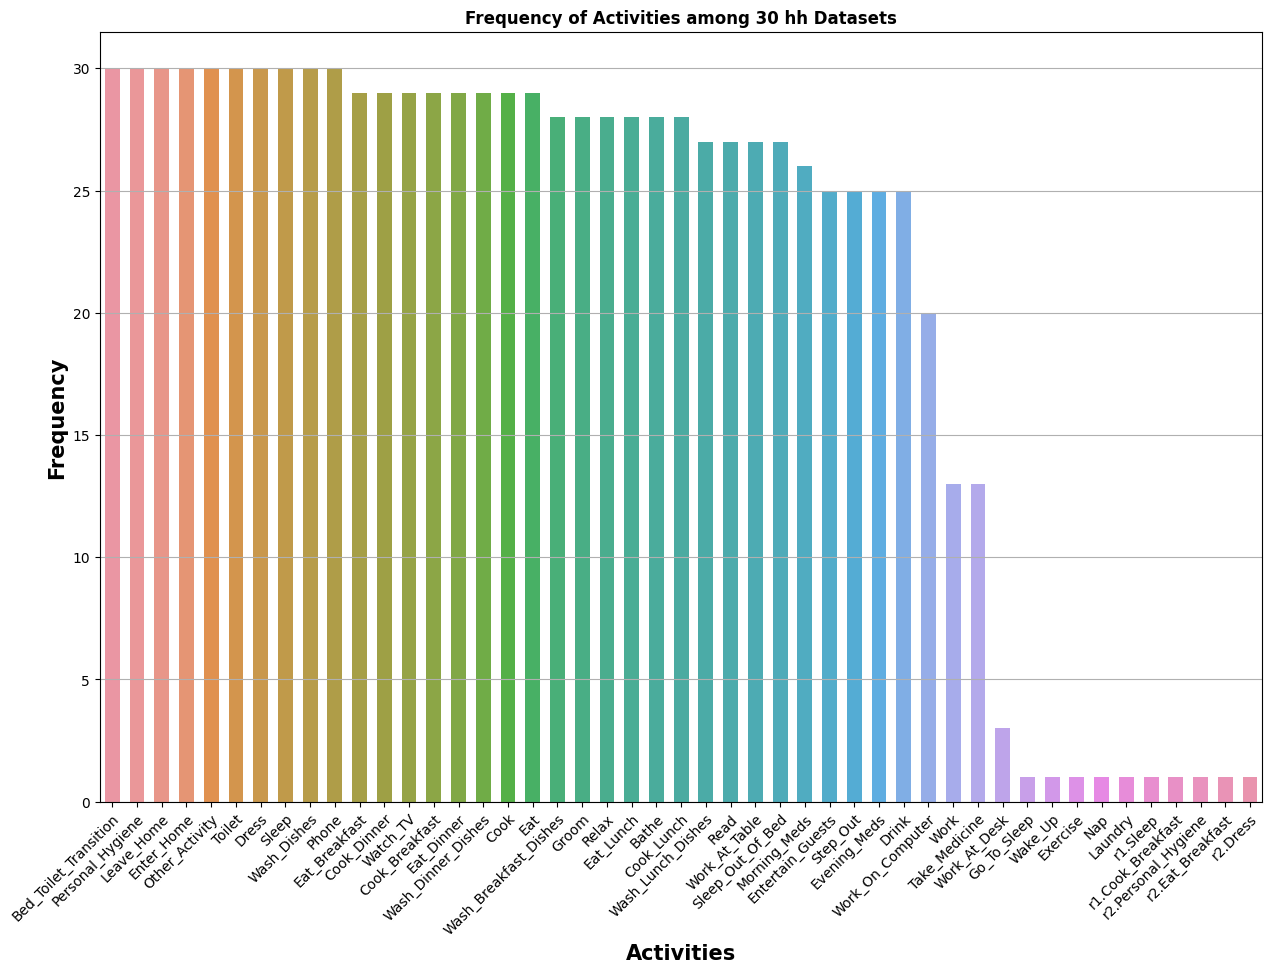

Index(['Entertain_Guests', 'Step_Out', 'Evening_Meds', 'Drink',
       'Work_On_Computer', 'Work', 'Take_Medicine', 'Work_At_Desk',
       'Go_To_Sleep', 'Wake_Up', 'Exercise', 'Nap', 'Laundry', 'r1.Sleep',
       'r1.Cook_Breakfast', 'r2.Personal_Hygiene', 'r2.Eat_Breakfast',
       'r2.Dress'],
      dtype='object')

In [18]:
# plot the histogram
fig, ax = plt.subplots(figsize=(15, 10))
# use seaborn to plot the histogram
ax.grid(True)
# rotate the xticks
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.barplot(x=activities_list.index, y=activities_list.values, ax=ax, width=0.6)
# bold the xlabel and ylabel, title

ax.set_xlabel('Activities', fontweight='bold', fontsize=15)
ax.set_ylabel('Frequency', fontweight='bold', fontsize=15)
ax.set_title('Frequency of Activities among 30 hh Datasets', fontweight='bold')

# rotate the xticks
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right' ,rotation_mode='anchor')
# add grid
plt.show()

# get the list of activities that appear less than 25 times
activities_list[activities_list <= 25].index

In [40]:
anchor_labels = ['Bathe', 'Enter_home', 'Wash_Dishes', 'Relax', 'Work', 'Sleep', 'Leave_home', 'Cook', 'Eat', 'Personal_Hygiene', 'Bed_Toilet_Transition']
activity_mapping = {
    'Cook': 'Cook',
    'Cook_Dinner': 'Cook',
    'Cook_Lunch': 'Cook',
    'Cook_Breakfast': 'Cook',
    'Eat_Dinner': 'Eat',
    'Eat_Lunch': 'Eat',
    'Eat_Breakfast': 'Eat',
    'Wash_Breakfast_Dishes': 'Wash_Dishes',
    'Wash_Lunch_Dishes': 'Wash_Dishes',
    'Wash_Dinner_Dishes': 'Wash_Dishes',
    'Toilet': 'Personal_Hygiene',
    'Groom': 'Personal_Hygiene',
    'Work_At_Computer': 'Work',
    'Work_On_Computer': 'Work',
    'Bathe': 'Bathe',
    'Relax': 'Relax',
    'Sleep': 'Sleep',
    'Enter_Home': 'Enter_home',
    'Leave_Home': 'Leave_home',
    'Bed_To_Toilet_Transition': 'Bed_Toilet_Transition',
    'Work': 'Work',
    'Work_At_Table': 'Work',
    'Eat': 'Eat',
    'Cook': 'Cook',
}

In [47]:
datasets_name = [str(i) for i in range(101, 131)]
activity_counting = {}
for dataset in datasets_name:
    activity_counting[dataset] = {}
    df, start, end, activity2id = read_hh_dataset('../hh_dataset/hh' + dataset + '/hh' + dataset + '.ann.txt')
    # df.to_csv('../hh_dataset/hh' + i + '/hh' + i + '.ann.csv')
    # Count the number of activities in each dataset
    df = df.loc[df['Activity'] != 'Other_Activity']

    df = df.loc[df['Activity'].shift(-1) != df['Activity']]

    # filter other activities

    # map the activities
    df['Activity'] = df['Activity'].map(activity_mapping)

    # filter not in anchor_labels
    df = df.loc[df['Activity'].isin(anchor_labels)]
    
    counting = df['Activity'].value_counts()
    # only store the top 10 activities
    for i in range(len(counting)):
        activity_counting[dataset][counting.index[i]] = counting[i]
    # store the rest of the activities as 'Other_Activity'
    # activity_counting[dataset]['Other_Activity'] = len(df) - sum(counting[:10])

    # break
# drop the 'Other_Activity' key
# activity_counting.pop('Other_Activity')

In [48]:
activity_counting

{'101': {'Personal_Hygiene': 391,
  'Leave_home': 171,
  'Enter_home': 170,
  'Cook': 137,
  'Eat': 110,
  'Sleep': 75,
  'Relax': 73,
  'Bathe': 55,
  'Wash_Dishes': 53,
  'Work': 4},
 '102': {'Personal_Hygiene': 399,
  'Cook': 223,
  'Work': 154,
  'Eat': 144,
  'Wash_Dishes': 133,
  'Relax': 123,
  'Leave_home': 118,
  'Enter_home': 118,
  'Sleep': 116,
  'Bathe': 35},
 '103': {'Personal_Hygiene': 358,
  'Cook': 213,
  'Eat': 209,
  'Sleep': 174,
  'Leave_home': 166,
  'Enter_home': 165,
  'Wash_Dishes': 140,
  'Work': 79,
  'Relax': 56,
  'Bathe': 23},
 '104': {'Personal_Hygiene': 405,
  'Sleep': 370,
  'Work': 318,
  'Cook': 228,
  'Leave_home': 207,
  'Enter_home': 207,
  'Eat': 177,
  'Wash_Dishes': 76,
  'Relax': 65,
  'Bathe': 20},
 '105': {'Personal_Hygiene': 252,
  'Leave_home': 219,
  'Enter_home': 219,
  'Cook': 190,
  'Eat': 106,
  'Work': 102,
  'Relax': 95,
  'Sleep': 84,
  'Wash_Dishes': 57,
  'Bathe': 17},
 '106': {'Leave_home': 246,
  'Enter_home': 245,
  'Work': 238

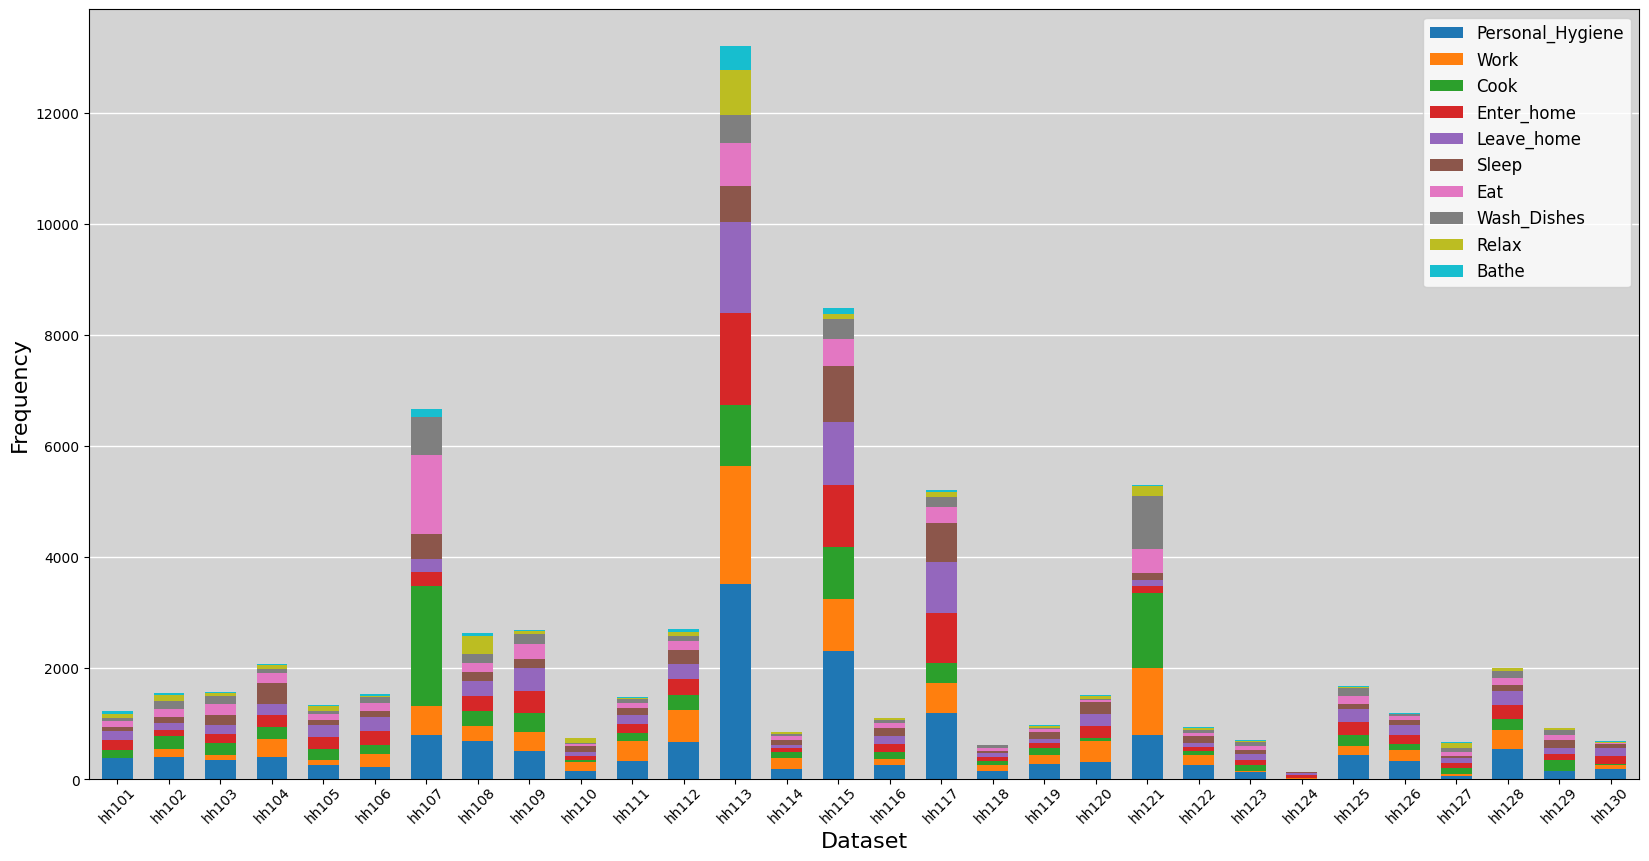

In [77]:
activity_df = pd.DataFrame(activity_counting).fillna(0)

# perform log transformation
# activity_df = np.log2(activity_df + 1)

# plot the bar chart with dataset as x-axis and activities as y-axis
fig, ax = plt.subplots(figsize=(20, 10))
# use seaborn to plot the histogram

# sort the dataset by the total number of activities
activity_df['total'] = activity_df.sum(axis=1)
activity_df = activity_df.sort_values(by='total', ascending=False)
activity_df = activity_df.drop('total', axis=1)

# plot the stacked bar chart with thin width between each bar
activity_df.T.plot(kind='bar', stacked=True, width=0.6, ax=ax, align='center')

# rotate the xticks and add "hh" prefix
ax.set_xticklabels(['hh' + str(i) for i in range(101, 131)], rotation=45)
# add y-axis grid
# set grey background
ax.set_facecolor('lightgrey')

# make x ticks closer
ax.tick_params(axis='x', which='major', pad=0)

# set grid behind the bars
ax.set_axisbelow(True)
ax.grid(axis='y', color='white', linestyle='-', linewidth=1)

# rotate the xticks
ax.set_xlabel('Dataset')
ax.set_ylabel('Frequency')

# larger x y label font size
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)


# larger legend font size
ax.legend(fontsize=12)


Text(0.5, 1.0, 'Number of Activities in HH Dataset')

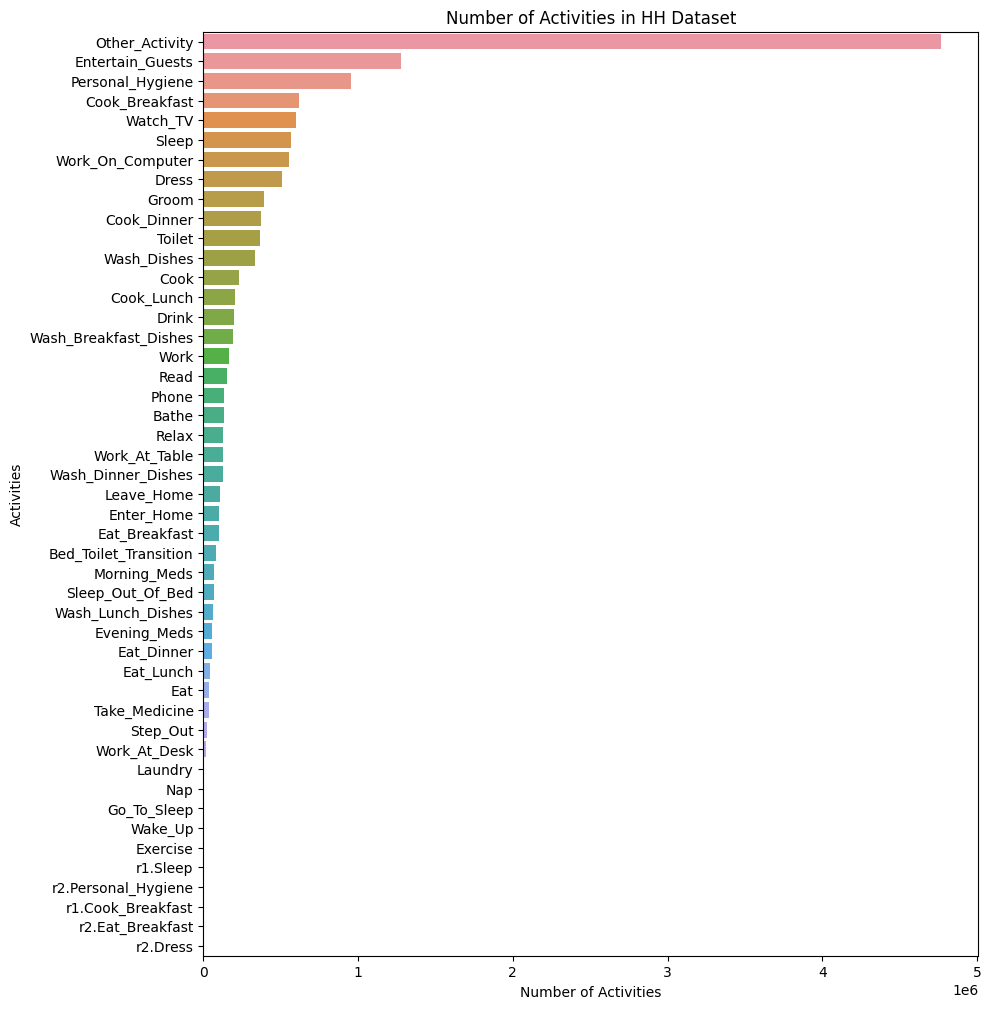

In [8]:
activity_counting = pd.Series(activity_counting).sort_values(ascending=False)
# plot the histogram
fig, ax = plt.subplots(figsize=(10, 12))
# use seaborn to plot the histogram
sns.barplot(x=activity_counting.values, y=activity_counting.index, ax=ax)
ax.set_xlabel('Number of Activities')
ax.set_ylabel('Activities')
ax.set_title('Number of Activities in HH Dataset')